In [1]:
from pathlib import Path

import matplotlib as mpl
import polars as pl
import seaborn as sns
from atollgen_cli.runner import DataHolder
from entrez_fetcher.genome_store import GenomeStore
from matplotlib import pyplot as plt
from scibelt.aggregates import Dataset, aggregate_format, format_data
from scibelt.viz import (
    FigureSaver,
    alias_or_name,
    latex_size,
)
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind


In [2]:
data_holder = DataHolder(Path("../data/interim/"), ensure_data=False)
adb_path = data_holder.db_dir / "adb"
adb_sources_dir = data_holder.db_dir / "sources"
genome_store_dir = data_holder.db_dir / "genomes"
genome_store = GenomeStore(genome_store_dir)

ds = Dataset.from_folder(
    "../data/post-process/base_nooverlaps/", genome_store=genome_store
)

fs = FigureSaver("../figures/supp/fig02/")

In [3]:
seqlens = ds.islands.select("label", "seq_len")

colors_phylum = {
    info.get("alias", name): info["color"]
    for name, info in format_data["phylum_8"].items()
}

filt_islands = ds.islands.join(ds.phylum, on="index")
filt_islands = aggregate_format(filt_islands, index="phylum", index_key="phylum")
filt_islands = filt_islands.filter(
    pl.col("phylum").is_in(alias_or_name(format_data["phylum_8"]))
    & (pl.col("label") != "ψICE")
)


In [4]:
data = {}
to_test = filt_islands.to_pandas()
for label, df in to_test.groupby("label"):
    ref = df.query("phylum == 'Bacillota'").seq_len
    for (phylum, subdf) in df.groupby("phylum"):
        ttest = ttest_ind(np.log(subdf["seq_len"]), np.log(ref), equal_var=False)
        data[(label, phylum)] = {"t": ttest.statistic, "pvalue": ttest.pvalue}

df = pd.DataFrame(data)
df = df.unstack()
df = df.unstack(1).dropna(how="all", axis=1).dropna(how="all").T

pvalues = df.xs("pvalue", level=1, axis=1)
cfs = pvalues.copy()
cfs[:] = "ns"
for i, confidence in enumerate([0.05, 0.01, 0.001], 1):
    cfs = cfs.where(pvalues > confidence, i * "*")
cfs.loc["Bacillota"] = ""
cfs

/tmp/ipykernel_9712/3804378186.py:6: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  ttest = ttest_ind(np.log(subdf["seq_len"]), np.log(ref), equal_var=False)


ICE   IE  IME psiICE  uGI
Actinomycetota         ns  ***   ns    ***  ***
Bacillota                                      
Bacteroidota          ***  ***   ns      *    *
Enterobacterales γp.  ***  ***   **     ns  ***
Pseudomonadales γp.   ***  ***  ***     ns  ***
Pseudomonadota        ***  ***   ns     ns  ***
Vibrionales γp.       ***  ***    *    ***  ***
Xanthomonadales γp.   ***  ***    *    ***  ***

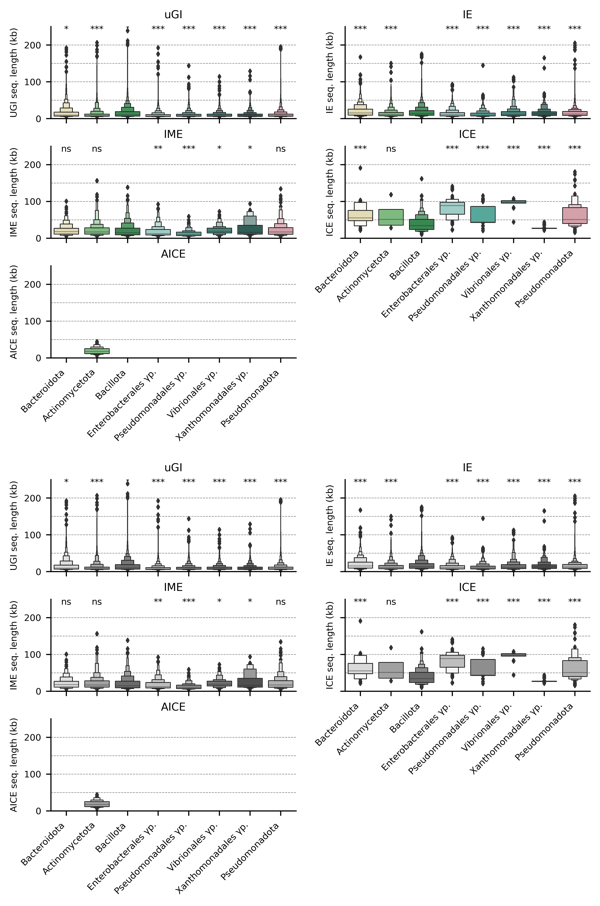

In [5]:
kb_formatter = mpl.ticker.FuncFormatter(lambda x, pos: f"{x / 1000:.0f}")
df = filt_islands.filter(pl.col("label") != "psiICE").to_pandas()
with latex_size(double=True):
    fig, axs = plt.subplots(3, 2, sharex=True, sharey=True)
    grp = df.groupby("label")
    labels = list(format_data["label"].keys())
    labels.remove("psiICE")
    for ax, label in zip(axs.flatten(), labels):
        subdf = grp.get_group(label)
        palette = {
            info.get("alias", name): info["color"]
            for name, info in format_data["phylum_8"].items()
            if name != "Others"
        }
        # ax.grid(axis="y")
        with plt.rc_context({"lines.markersize": 2}):
            sns.boxenplot(
                x="phylum",
                y="seq_len",
                data=subdf,
                ax=ax,
                palette=palette,
                order=palette.keys(),
                linewidth=0.6,
            )
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_ylim(0, 250e3)
        ax.set_title(label)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
        ax.yaxis.set_major_formatter(kb_formatter)
        ax.xaxis.grid(False, which="both")
        ax.set_axisbelow(True)
        ax.set_ylabel(f"{label.upper()} seq. length (kb)")
        locs, labels = plt.yticks()
        for loc in locs[:-1]:
            ax.axhline(y=loc, color="grey", linestyle="--", linewidth=0.4, zorder=-10)
        yfact = ax.get_ylim()[1] * 0.05
        if label == "AICE":
            continue
        for i, phylum in enumerate(palette.keys()):
            cf = cfs.loc[phylum.split("\n")[0], label]
            y = min(
                subdf[subdf.phylum == phylum].seq_len.max() + yfact,
                ax.get_ylim()[1] - yfact,
            )
            # ax.text(i, 280e3, f"{cf}\n{len(subdf[subdf.phylum == phylum]):,}", horizontalalignment="center", fontstyle="italic")
            ax.text(
                i,
                230e3,
                f"{cf}",
                horizontalalignment="center",
                verticalalignment="bottom",
            )
    fig.delaxes(axs[-1][-1])
    axs[1, 1].tick_params(
        axis="x",  # changes apply to the x-axis
        bottom="on",  # ticks along the bottom edge are off
        labelbottom="on",  # labels along the bottom edge are off)
    )
    plt.subplots_adjust(hspace=0.3)
fs.savefig(fig, "panel")
